# Introducción

En este notebook se desarrollan cuatro formas de calcular los parámetros de una regresión (Beta0, Beta1 y Sigma):

* Fórmulas explícitas
* Matrices
* Gradiente
* Librería Statsmodels de Python

En esta seción se importan las librerías y se genera un conjunto de datos $(X,y)$ sobre los que se va a realizar la estimación de los parámetros. Primero se genera la variable independiente $x$ y se construye la matriz

\begin{align}
        X = \begin{pmatrix}
        1 & x_1 &  \\
        1 & x_2 & \\ 
        ... & ... \\
        1 & x_n
        \end{pmatrix}
    \end{align}


Después, a partir de los parámetros $\beta_0$, $\beta_1$ y $\sigma$ generamos la variable dependiente $y$ con el modelo

\begin{align}
      y_i=\beta_0 + \beta_1 x_i + \epsilon_i
      \end{align}

Donde $\epsilon_i$ son $iid$  $N(0,\sigma^2)$

Después guardamos el resultado de la simulación en el vector $y$

\begin{align}
        y = \begin{pmatrix}
        y_1 \\
        y_2 \\ 
        ...\\
        y_n
        \end{pmatrix}
    \end{align}




In [76]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


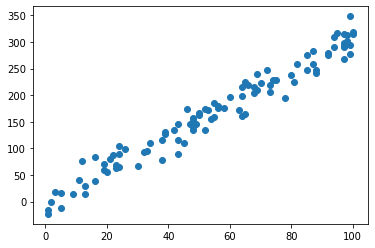

In [77]:
# Generar los datos
# Parámetros
obs=100
parametros=(2,3)
sigma=20
# Variable independiente
X=np.vstack((np.ones(obs),np.round(np.random.random(obs)*100))).T
x=X[:,1]
# Variable dependiente
y=np.matmul(X,parametros) + np.random.standard_normal(obs)*sigma
# Hacer un gráfico
plt.scatter(x,y);

# Guardar los parámetros en el DataFrame resumen
resumen=pd.DataFrame(columns=['Beta0', 'Beta1', 'Sigma'])
resumen.loc['Parámetros',['Beta0', 'Beta1', 'Sigma']]=[parametros[0],parametros[1],sigma]
  

# Statsmodels

Los parámetros se estiman directamente con la sentencia correspondiente de StatsModels


In [78]:
# Statsmodel
import statsmodels.api as sm

modelo = sm.OLS(y,X).fit()

#Guardar resultados en el DataFrame resumen
resumen.loc['StatsModels',['Beta0', 'Beta1', 'Sigma']
            ]=[modelo.params[0],modelo.params[1],np.sqrt(modelo.ssr/(obs-2))]
resumen.loc['StatsModels']


Beta0    -1.2443
Beta1    3.08127
Sigma    18.5337
Name: StatsModels, dtype: object

# Fórmulas explicitas

Las fórmulas utilizadas para la estimación de los parámetros son:


Primero realizamos los cálculos intermedios

\begin{align}
      S_{xy}=\frac{1}{n}\sum_{i=1}^{n}x_iy_i-\overline{x}\overline{y}
      \end{align}

\begin{align}
  S_{xx}=\frac{1}{n}\sum_{i=1}^{n}x_i^2-\overline{x}^2
     \end{align}

Para calcular las betas:

\begin{align}
  \beta_1=\frac{S_{xy}}{S_{xx}}
     \end{align}
\begin{align}
  \beta_0=\overline{y}-\beta_1\overline{x}
       \end{align}

El parámetro $\sigma$ lo estimamos como la raiz cuadrada de la suma de los residuos al cuadrado dividido por los grados de libertad



\begin{align}
  \sigma=\sqrt{\frac{\sum_{i=1}^{n}(y_i-\beta_0-\beta_1x_i)^2}{n-2}}
       \end{align}



In [79]:
# Fórmulas explícitas
sxy=1/obs*np.dot(x,y)-np.mean(x)*np.mean(y)
sxx=1/obs*np.dot(x,x)-np.mean(x)**2
beta1=sxy/sxx
beta0=np.mean(y)-beta1*np.mean(x)
residuos=y-beta0-beta1*x
sigma=np.sqrt(sum(residuos**2)/(obs-2))

#Guardar resultados en el DataFrame resumen
resumen.loc['Formula',['Beta0', 'Beta1', 'Sigma']]=[beta0,beta1,sigma]
resumen.loc['Formula']




Beta0    -1.2443
Beta1    3.08127
Sigma    18.5337
Name: Formula, dtype: object

# Matrices

El procedimiento es análogo al procedimiento anterior pero usando la notación matricial:

Partiendo de la expresión matricial del modelo 

\begin{align}
  Y=X\beta+𝛆
   \end{align}

Podemos calcular las betas imponiendo las condiciones de ortogonalidad $X'𝜀=0$, ( es decir, las condiciones son (i) la suma de residuos es igual a cero y (ii) los residuos son ortogoales a la variable independiente) y despejando

\begin{align}
    \beta=(X'X)^{-1}Y
      \end{align}

Finalmente se calcularía el parámetro $\sigma$ como la raiz cuadrada de la suma de los residuos al cuadrado dividido por los grados de libertad, como en el apartado anterior


In [80]:
# Cálculo con matrices
betas=np.matmul(np.matmul(np.linalg.inv(np.matmul(X.T,X)),X.T),y)
residuos=y-np.matmul(X,betas)
sigma=np.sqrt(sum(residuos**2)/(obs-2))


#Guardar resultados en el DataFrame resumen
resumen.loc['Matrices',['Beta0', 'Beta1', 'Sigma']]=[betas[0],betas[1],sigma]
resumen.loc['Matrices']

Beta0    -1.2443
Beta1    3.08127
Sigma    18.5337
Name: Matrices, dtype: object

# Gradiente

Este método es iterativo. Se parte de una solución inicial aleatoria para las betas del modelo. Esta solución inicial se va corrigiendo en sucesivas iteraciones disminuyendo la función de coste en cada iteración, siendo la función de coste la suma de los residuos al cuadrados. A efectos ilustrativos se utiliza un algoritmo muy simple, por lo que la convergencia es poco eficiente, no obstante se puede pareciar con claridad cómo funciona el algoritmo.

La actualización de las betas en cada iteración se hace restando el gradiente de la función de coste.
El gradiente de la función de coste es la variación de la función de coste por un incremento del parámetro. Dado que lo que se pretende es bajar el coste, actualizamos el parámetro restando una pequeña fracción de la derivada de la función de coste respecto de dicho parámetro.

\begin{align}
    \beta_{nuevos}=\beta_{viejos}-λ\Delta C
      \end{align}

Donde $\lambda$ es un parámetro del algoritmo que elegimos nosotros y $\Delta C$ es el gradiente de la función de coste

\begin{align}
  \Delta C=(\frac{\partial C}{\partial\beta_0},\frac{\partial C}{\partial \beta_1})
    \end{align}

y la función de coste es la suma de los residuos al cuadrado

\begin{align}
    C=\sum_{i=1}^{n}(y_i-\beta_0-\beta_1x_i)^2
    \end{align}

Nota: Ojo, en el algoritmo se ha omitido el factor 2 de las derivadas parciales de la función de coste y se ha tendo en cuenta el signo negativo de las betas. 

In [81]:
#Solucion con gradient descent

# Solucion inicial
betas=np.random.random(2)
lamb=0.000001
residuos=y-np.matmul(X,betas)
coste=np.sum(np.square(residuos))
sigma=np.sqrt(coste/(obs-2))

df=pd.DataFrame([(coste,betas[0],betas[1],sigma)], columns=['Coste','Beta0','Beta1','Sigma'])


# Algoritmo iterativo 
for i in range(200): 
  gradiente=np.matmul(residuos.T,X)
  betas=betas+lamb*gradiente
  residuos=y-np.matmul(X,betas)
  coste=np.sum(np.square(residuos))
  sigma=np.sqrt(coste/(obs-2))
  df=df.append({'Coste':coste,'Beta0':betas[0],'Beta1':betas[1],'Sigma':sigma},ignore_index=True)

#Guardar resultados en el DataFrame resumen
resumen.loc['Gradiente',['Beta0', 'Beta1', 'Sigma']]=[betas[0],betas[1],sigma]


# Imprimir los resultados de las 5 ultimas iteraciones
df.tail()

,Coste,Beta0,Beta1,Sigma
196,33709.314806,0.199198,3.060829,18.546498
197,33709.312722,0.199166,3.060829,18.546498
198,33709.310639,0.199134,3.060830,18.546497
199,33709.308555,0.199101,3.060830,18.546497
200,33709.306472,0.199069,3.060831,18.546496


# Resumen de los parámetros
En las celdas anteriores se han guardado los parámetros obtenidos en cada uno de los procedimientos en el dataframe resumen. En la primera fila del datafame se ha guardado los parámetros con los que se han generado inicialmente los datos $X,y$.

Los parámetros iniciales son los parámetros "verdaderos", $(\beta_0,\beta_1,\sigma)$ y los parámetros obtenidos por los diferentes procedimientos son los parámetros estimados $(\hat{\beta_0},\hat{\beta_1},\hat{\sigma}) $


In [82]:
resumen

,Beta0,Beta1,Sigma
Parámetros,2,3,20
StatsModels,-1.2443,3.08127,18.5337
Formula,-1.2443,3.08127,18.5337
Matrices,-1.2443,3.08127,18.5337
Gradiente,0.199069,3.06083,18.5465
